<a href="https://colab.research.google.com/github/ziadbadwy/brainTumorClassification/blob/main/brain_VS_breast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import warnings

warnings.filterwarnings('ignore')
import numpy
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import shutil
import glob

import random
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D ,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model

from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

from google.colab import files

#shutil.rmtree('/content/Train/')
	



In [2]:
uploaded = files.upload()


Saving CV.zip to CV.zip
Saving Test.zip to Test.zip
Saving Train.zip to Train.zip


In [8]:
!unzip /content/CV.zip
!unzip /content/Train.zip
!unzip /content/Test.zip

Archive:  /content/CV.zip
   creating: CV/brain/
  inflating: CV/brain/no501.jpg      
  inflating: CV/brain/no502.jpg      
  inflating: CV/brain/no503.jpg      
  inflating: CV/brain/no504.jpg      
  inflating: CV/brain/no505.jpg      
  inflating: CV/brain/no506.jpg      
  inflating: CV/brain/no507.jpg      
  inflating: CV/brain/no508.jpg      
  inflating: CV/brain/no509.jpg      
  inflating: CV/brain/no510.jpg      
  inflating: CV/brain/no511.jpg      
  inflating: CV/brain/no512.jpg      
  inflating: CV/brain/no513.jpg      
  inflating: CV/brain/no514.jpg      
  inflating: CV/brain/no515.jpg      
  inflating: CV/brain/no516.jpg      
  inflating: CV/brain/no517.jpg      
  inflating: CV/brain/no518.jpg      
  inflating: CV/brain/no519.jpg      
  inflating: CV/brain/no520.jpg      
  inflating: CV/brain/no521.jpg      
  inflating: CV/brain/no522.jpg      
  inflating: CV/brain/no523.jpg      
  inflating: CV/brain/no524.jpg      
  inflating: CV/brain/no525.jpg      
 

In [45]:
#count images according to classes 
pathTrain="/content/Train/"
pathCV = "/content/Test/"
pathTest="/content/CV/"

numberOfTrain = {}
numberOfCV = {}
numberOfTest={}

images_train_data={}
images_CV_data={}
images_Test_data={}


pathOfEachTrain=[]
pathOfEachCV=[]
pathOfEachtest=[]

for dir in os.listdir(pathTrain):
  images_train_data[dir]=os.listdir(os.path.join(pathTrain,dir))
  pathOfEachTrain.append(os.path.join(pathTrain,dir))
  numberOfTrain[dir] = len(os.listdir(os.path.join(pathTrain,dir)))
for dir in os.listdir(pathCV):
  images_CV_data[dir]=os.listdir(os.path.join(pathCV,dir))
  pathOfEachCV.append(os.path.join(pathCV,dir))
  numberOfCV[dir] = len(os.listdir(os.path.join(pathCV,dir)))
for dir in os.listdir(pathTest):
  images_Test_data[dir]=os.listdir(os.path.join(pathTest,dir))
  pathOfEachtest.append(os.path.join(pathTest,dir))
  numberOfTest[dir] = len(os.listdir(os.path.join(pathTest,dir)))


In [46]:
#data augm train
trainGen = ImageDataGenerator(
                             vertical_flip=True,
                             rescale=1/255

                             )

Train_prepare = trainGen.flow_from_directory(directory = pathTrain,target_size=(224,224),batch_size=32,class_mode='binary')
image1=cv2.imread(Train_prepare.filepaths[100])
image2=cv2.imread(Train_prepare.filepaths[1000])

Found 1682 images belonging to 2 classes.


Found 150 images belonging to 2 classes.
Found 149 images belonging to 2 classes.


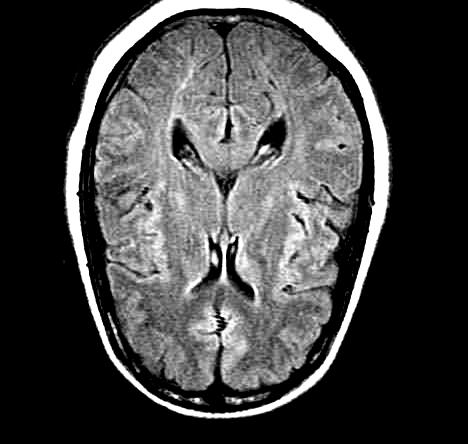

In [55]:
datagen = ImageDataGenerator(
                             rescale=1/255
                             )
test_prepare = datagen.flow_from_directory(directory = pathTest,target_size=(224,224),batch_size=7,class_mode='binary')
test_prepare

CV_prepare = datagen.flow_from_directory(directory = pathCV,target_size=(224,224),batch_size=6,class_mode='binary')
CV_prepare

image1=cv2.imread(CV_prepare.filepaths[5])
cv2_imshow( image1)


In [56]:
es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=3,verbose=1,mode='auto')
mc = ModelCheckpoint(monitor="val_accuracy",filepath="mymodel.h5",save_best_only=True,verbose=1,mode='auto') 
cd=[es,mc] 


In [36]:
MN = MobileNet(input_shape=(224,224,3),include_top=False)

17225924/17225924 [==============================] - 1s 0us/step


In [49]:
for layer in MN.layers:
    layer.trainable = False

In [50]:
Out = Flatten()(MN.output)
Out = Dense(1,activation='sigmoid')(Out)

In [51]:

model = Model(inputs = MN.input,outputs=Out)
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [52]:
model.compile(
    loss=binary_crossentropy,
    metrics=['accuracy'],
    optimizer=Adam(0.001)
)

In [57]:
final=model.fit_generator(generator=Train_prepare
                          ,steps_per_epoch=10
                          ,epochs=30
                          ,verbose=1
                          ,validation_data=CV_prepare
                          ,validation_steps=16
                          ,callbacks=cd)

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 3.7065e-15 - accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to mymodel.h5
10/10 [==============================] - 3s 282ms/step - loss: 3.7065e-15 - accuracy: 1.0000 - val_loss: 8.1940e-20 - val_accuracy: 1.0000
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 3.5222e-15 - accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
10/10 [==============================] - 2s 236ms/step - loss: 3.5222e-15 - accuracy: 1.0000 - val_loss: 8.2638e-20 - val_accuracy: 1.0000
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 3.5187e-15 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
10/10 [==============================] - 2s 241ms/step - loss: 3.5187e-15 - accuracy: 1.0000 - val_loss: 8.2968e-20 - val_accuracy: 1.0000
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 3.3293e-19 - accuracy: 1.0000
Epoch 4: 

In [58]:
f=final.history
print(f.keys())
print(max(f['accuracy']))
print(max(f['val_accuracy']))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
1.0
1.0


In [60]:
model = load_model("/content/BrainTumor.h5")

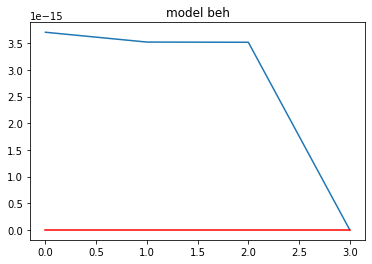

In [61]:
plt.plot(f['loss'])
plt.plot(f['val_loss'],c="red")
plt.title("model beh")
plt.show()


In [62]:
#acc
acc=model.evaluate_generator(test_prepare)[1]
print(f"the accuracy is {acc*100} %")

the accuracy is 100.0 %


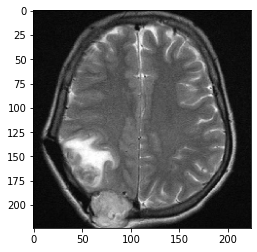

1/1 [==============================] - 0s 21ms/step
[[3.925886e-22]]
brain


In [73]:
path = "/content/Test/brain/y796.jpg"
img = load_img(path,target_size=(224,224))
input_arr = img_to_array(img)/255
plt.imshow(input_arr)
plt.show()
input_arr=np.expand_dims(input_arr,axis=0)
pred=model.predict(input_arr)
print(pred)
if pred>0.5:
  print("breast")
else:
  print("brain")
